In [171]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from shapely.wkt import load

import clean_utils
from importlib import reload


In [172]:
reload(clean_utils)

<module 'clean_utils' from 'C:\\Users\\sadamerdji\\Desktop\\dissertation\\pdev\\clean_utils.py'>

### Load Data

In [173]:
parcels = pd.read_csv('../data/Blue Sky Code and Inputs/SF_Logistic_Data.csv')

In [174]:
allParcels = gpd.read_file('../data/Parcels   Active and Retired/parcels.shp')

In [175]:
sites = gpd.read_file('../data/site_inventory/xn--Bay_Area_Housing_Opportunity_Sites_Inventory__20072023_-it38a.shp')

In [176]:
tax = pd.read_excel('../data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx')

In [177]:
tax15 = pd.read_excel('../data/tax_assessor/2020.7.10_SF_ASR_Secured_Roll_Data_2015-2016.xlsx')

In [178]:
slopes = gpd.read_file('../data/Slopes of 20% Or Greater/geo_export_2dd8ac56-99a0-4a45-ba46-c85a7407e3e5.shp')

In [179]:
census = gpd.read_file('../data/Census 2000_ Tracts for San Francisco (no water)'
                       '/geo_export_4609700a-c230-4617-92b7-4ef34f23f741.shp')

In [180]:
sfneighborhoods = gpd.read_file('../data/SF Find Neighborhoods/geo_export_2ecdf278-8615-4538-9268-0d4992d30e52.shp')

In [181]:
home_prices = pd.read_csv('../data/efz/Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

In [182]:
home_prices = home_prices[home_prices.City == 'San Francisco']

In [183]:
home_prices = home_prices[['RegionName', '2007-01-31']]

In [184]:
home_prices = home_prices[home_prices.notna().all(axis=1)]

In [185]:
# These codes are the same in both 2007-2008 and 2015-2016
use_codes = pd.read_excel('../data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx', 
                          sheet_name='Class & Use Code')
neighborhood_codes = pd.read_excel('../data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx', 
                                   sheet_name='Neigborhood Code')

In [186]:
tax_data_keys = pd.read_excel('../data/tax_assessor/2019.8.20__SF_ASR_Secured_Roll_Data_2007-2008.xlsx', 
                                   sheet_name='Data Key')

### Geospatial version of bluesky data

In [187]:
def get_basic_df(cycle):
    if cycle == 4:
        start_year = 2007
    else:
        start_year = 2015
    trainParcels = parcels[(parcels.year >= start_year) & (parcels.year < (start_year + 8))]
    trainY = trainParcels.groupby('MapBlkLot_Master')['Developed'].agg(lambda x: x.ne(0).sum())
    trainX = trainParcels[trainParcels.year == start_year]
    trainDf = pd.merge(trainX.drop('Developed', axis=1), trainY, left_on='MapBlkLot_Master', right_index=True)
    df = clean_utils.transform_bluesky_to_geospatial(trainDf, cycle)
    return df

In [188]:
df4 = get_basic_df(4)

In [189]:
df4.head()

,MapBlkLot_Master,mapblklot,blklot,active,geometry,year,Historic,Residential_Dummy,Zillow_Price_Real,Const_FedReserve_Real,...,Upzone_Ratio,zp_OfficeComm,zp_DensRestMulti,zp_FormBasedMulti,zp_PDRInd,zp_Public,zp_Redev,zp_RH2,zp_RH3_RM1,Developed
0,0001001,0001001,0001001,T,"POLYGON ((-122.42200 37.80848, -122.42208 37.8...",2007,0,0,93.227099,92.120253,...,2.000000,0,0,0,0,1,0,0,0,0
1,0002001,0002001,0002001,T,"POLYGON ((-122.42083 37.80863, -122.42086 37.8...",2007,1,0,93.227099,92.120253,...,1.666667,1,0,0,0,0,0,0,0,0
2,0004002,0004002,0004002,T,"POLYGON ((-122.41570 37.80833, -122.41576 37.8...",2007,0,0,93.227099,92.120253,...,1.666667,1,0,0,0,0,0,0,0,0
3,0005001,0005001,0005001,T,"POLYGON ((-122.41735 37.80812, -122.41746 37.8...",2007,1,0,93.227099,92.120253,...,1.666667,1,0,0,0,0,0,0,0,0
4,0006001,0006001,0006001,T,"POLYGON ((-122.41897 37.80791, -122.41915 37.8...",2007,0,0,93.227099,92.120253,...,1.666667,1,0,0,0,0,0,0,0,0


In [190]:
#df5 = get_basic_df(5)

In [21]:
#df5.Developed.sum()

88

In [191]:
df4.Developed.sum()

253

In [23]:
#df5.Developed = df5.Developed >= 1

In [193]:
df4.Developed = df4.Developed >= 1

#### Get dbi permits from past cycle

In [192]:
pipeline3 = clean_utils.get_pipeline_permits(cycle=3)

In [26]:
#pipeline4 = clean_utils.get_pipeline_permits(cycle=4)

In [194]:
permit_type_map = {1: 'new construction',
                   2: 'new construction wood frame',
                   3: 'additions alterations or repairs',
                   4: 'sign',
                   5: 'grade or quarry or fill or excavate',
                   6: 'demolitions',
                   7: 'wall or painted sign',
                   8: 'otc alterations'}

permit_type_map = {k: '_'.join(v.split(' ')) for k, v in permit_type_map.items()}
permit_type_map = {str(k): v for k, v in permit_type_map.items()}
permit_type_map = {k: 'permit_' + v for k, v in permit_type_map.items()}
permit_type_map

{'1': 'permit_new_construction',
 '2': 'permit_new_construction_wood_frame',
 '3': 'permit_additions_alterations_or_repairs',
 '4': 'permit_sign',
 '5': 'permit_grade_or_quarry_or_fill_or_excavate',
 '6': 'permit_demolitions',
 '7': 'permit_wall_or_painted_sign',
 '8': 'permit_otc_alterations'}

### Merge into bluesky data

In [195]:
def merge_pipeline(df, pipeline):
    df = pd.merge(df, pipeline, left_on='blklot', right_index=True, how='left')
    df[pipeline.columns] = df[pipeline.columns].fillna(0)
    return df

In [196]:
df4 = merge_pipeline(df4, pipeline3)

In [30]:
#df5 = merge_pipeline(df5, pipeline4)

In [197]:
pipeline_columns = [c for c in df4.columns if c.startswith('permit')]

In [198]:
df4 = df4.rename(dict(zip(pipeline_columns, 
                          [permit_type_map.get(c[-1], c) for c in pipeline_columns])),
                 axis=1)

### Merge Tax Data

In [199]:
full_df4 = clean_utils.merge_tax(df4, tax, cycle=4, parcels=allParcels)

In [34]:
#full_df5 = clean_utils.merge_tax(df5, tax15, cycle=5, parcels=allParcels)

In [35]:
'''
full_df5.dtypes[~(full_df4.dtypes == full_df5.dtypes)]
full_df5.ROOMS = pd.to_numeric(full_df5.ROOMS, 
                               errors='coerce',
                               downcast='integer')
full_df5.STOREYNO = pd.to_numeric(full_df5.STOREYNO,
                                  errors='coerce',
                                  downcast='integer')
full_df5.FBA = pd.to_numeric(full_df5.FBA, 
                             errors='coerce',
                             downcast='integer')
                             
full_df5 = full_df5[full_df5.FBA.notna() &
full_df5.STOREYNO.notna() &
full_df5.ROOMS.notna()] 
'''

"\nfull_df5.dtypes[~(full_df4.dtypes == full_df5.dtypes)]\nfull_df5.ROOMS = pd.to_numeric(full_df5.ROOMS, \n                               errors='coerce',\n                               downcast='integer')\nfull_df5.STOREYNO = pd.to_numeric(full_df5.STOREYNO,\n                                  errors='coerce',\n                                  downcast='integer')\nfull_df5.FBA = pd.to_numeric(full_df5.FBA, \n                             errors='coerce',\n                             downcast='integer')\n                             \nfull_df5 = full_df5[full_df5.FBA.notna() &\nfull_df5.STOREYNO.notna() &\nfull_df5.ROOMS.notna()] \n"

### Feature Engineering

#### Use Codes

In [200]:
use_codes = use_codes[~use_codes.isna().all(axis=1)]

In [201]:
use_codes.head()

,USE,DESC,CLASS,DESC.1
0,SRES,Single Family Residential,CO,Coop Units Unsegregated
1,SRES,Single Family Residential,COS,Coop Units Segregated
2,SRES,Single Family Residential,D,Dwelling
3,SRES,Single Family Residential,DBM,Dwelling BMR
4,SRES,Single Family Residential,LZ,Live/Work Condominium


In [202]:
use_codes = use_codes[use_codes['CLASS'] != 'CLASS']
use_lookup = use_codes.groupby('CLASS')['USE'].agg(list).to_dict()
use_lookup = {k: v[-1] for k, v in use_lookup.items()}

In [203]:
full_df4['general_use_code'] = full_df4.RP1CLACDE.map(use_lookup)
#full_df5['general_use_code'] = full_df5.RP1CLACDE.map(use_lookup)

#### New features

In [204]:
full_df4['hasBMR'] = full_df4.RP1CLACDE.str.endswith('BM')
#full_df5['hasBMR'] = full_df5.RP1CLACDE.str.endswith('BM')

#### Neighborhood Code

In [205]:
neighborhood_codes.NEIGHBORHOOD = neighborhood_codes.NEIGHBORHOOD.str.strip().str.lower().str.split(' ').str.join('_')

In [206]:
neighborhood_codes.head()

,DISTRICT,CODE,NEIGHBORHOOD,BOUNDRIES
0,1,1A,central_richmond,"South of California, Park Presidio, south of F..."
1,1,1B,inner_richmond,"South of California, Arguello, south of Fulton..."
2,1,1C,jordan_park/laurel_heights,"California, west of Presidio, Geary, Arguello"
3,1,1D,lake_--the_presidio,"West and south of Presidio Terrace, Arguello, ..."
4,1,1E,outer_richmond,"The Ocean, west of 32nd Avenue, south of Fulton"


In [207]:
neighborhoods = {k: v[0] for k, v in neighborhood_codes.groupby('CODE')['NEIGHBORHOOD'].agg(list).to_dict().items()}
neighborhoods = {(k if len(k) == 3 else '0'+k): v for k, v in neighborhoods.items()} 

In [208]:
def lookup_neighborhood(x):
    return neighborhoods.get(x, x)

In [209]:
full_df4['neighborhood'] = full_df4.RP1NBRCDE.apply(lookup_neighborhood)
#full_df5['neighborhood'] = full_df5.RP1NBRCDE.apply(lookup_neighborhood)

In [210]:
full_df4 = full_df4.replace({'neighborhood': 
                             {'047': 'west_portal', 
                              '08I': 'union_square', 
                              '09B': 'financial_district_south'}})

In [211]:
districts = {k: v[0] for k, v in neighborhood_codes.groupby('CODE')['DISTRICT'].agg(list).to_dict().items()}
districts = {(k if len(k) == 3 else '0'+k): v for k, v in districts.items()} 

In [213]:
def lookup_district(x):
    if x in districts:
        return str(districts[x])
    elif str(x)[1] in map(str, districts.values()):
        return str(x)[1]
    return str(x)

In [214]:
full_df4['district'] = full_df4['RP1NBRCDE'].apply(lookup_district)
#full_df5['district'] = full_df5['RP1NBRCDE'].apply(lookup_district)

In [215]:
full_df4 = full_df4.drop('RP1NBRCDE', axis=1)
#full_df5 = full_df5.drop('RP1NBRCDE', axis=1)

In [216]:
full_df4 = full_df4.reindex()
#full_df5 = full_df5.reindex()

In [218]:
full_df4.columns

Index(['MapBlkLot_Master', 'mapblklot', 'blklot', 'active', 'geometry', 'year',
       'Historic', 'Residential_Dummy', 'Zillow_Price_Real',
       'Const_FedReserve_Real', 'Envelope_1000', 'Upzone_Ratio',
       'zp_OfficeComm', 'zp_DensRestMulti', 'zp_FormBasedMulti', 'zp_PDRInd',
       'zp_Public', 'zp_Redev', 'zp_RH2', 'zp_RH3_RM1', 'Developed',
       'permit_costs', 'permit_new_construction',
       'permit_new_construction_wood_frame',
       'permit_additions_alterations_or_repairs', 'permit_sign',
       'permit_grade_or_quarry_or_fill_or_excavate', 'permit_demolitions',
       'permit_wall_or_painted_sign', 'permit_otc_alterations', 'PROPLOC',
       'RP1PRCLID', 'RP1VOLUME', 'RP1CLACDE', 'YRBLT', 'BATHS', 'BEDS',
       'ROOMS', 'STOREYNO', 'UNITS', 'ZONE', 'CONSTTYPE', 'DEPTH', 'FRONT',
       'SQFT', 'FBA', 'LAREA', 'LOTCODE', 'REPRISDATE', 'RP1TRACDE',
       'OWNRPRCNT', 'EXEMPTYPE', 'RP1STACDE', 'RP1EXMVL2', 'RP1EXMVL1',
       'ROLLYEAR', 'RECURRSALD', 'RP1FXTVAL', 'R

In [237]:
full_df4.RECURRSALD = full_df4.RECURRSALD.astype(str).apply(lambda x: (6 - len(x)) * "0" + x if 3 <= len(x) < 6 else x)

In [249]:
full_df4.RECURRSALD = full_df4.RECURRSALD.astype(str).apply(lambda x: x[:2] + '/' + x[2:4] + '/' + x[4:] if len(x) == 6 else x)

## Slopes, Census Tracts, Rents

<Figure size 640x480 with 0 Axes>

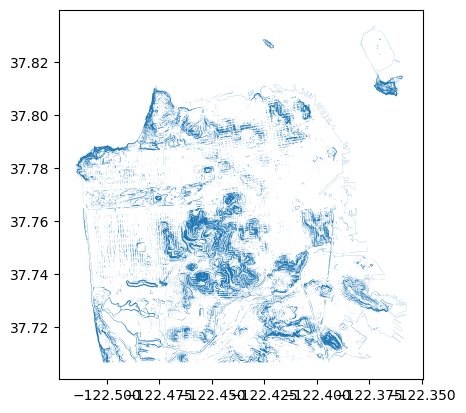

In [250]:
plt.clf()
slopes.plot()
plt.show()

In [251]:
full_df4_slopes = gpd.sjoin(full_df4, slopes[['geometry']], how="left", predicate='within')

In [252]:
full_df4_slopes.index_right.isna().mean().round(2)

0.99

In [253]:
full_df4_slopes2 = gpd.sjoin(full_df4, slopes[['geometry']], how="left", predicate='contains')

In [254]:
full_df4_slopes2.index_right.isna().mean().round(2)

0.97

In [255]:
full_df4_slopes = full_df4_slopes.rename({'index_right': 'steep_lot'}, axis=1)

In [256]:
full_df4_slopes2 = full_df4_slopes2.rename({'index_right': 'steep_lot'}, axis=1)

In [257]:
full_df4_slopes.steep_lot = full_df4_slopes.steep_lot.notna()

In [258]:
full_df4_slopes2.steep_lot = full_df4_slopes2.steep_lot.notna()

In [259]:
full_df4_slopes.steep_lot.mean()

0.014594919192710373

In [260]:
full_df4_slopes2.steep_lot.mean()

0.02778370893750283

In [261]:
#full_df4_slopes2[['CANTID_blklot_backup', 'CANTID_geometry_backup']] = full_df4_slopes2[['CANTID_blklot_backup', 
#                                                                                         'CANTID_geometry_backup']].astype(str)

In [262]:
full_df4_slopes2 = full_df4_slopes2.drop_duplicates()

In [263]:
full_df4_slopes2.shape

(153204, 66)

<Figure size 640x480 with 0 Axes>

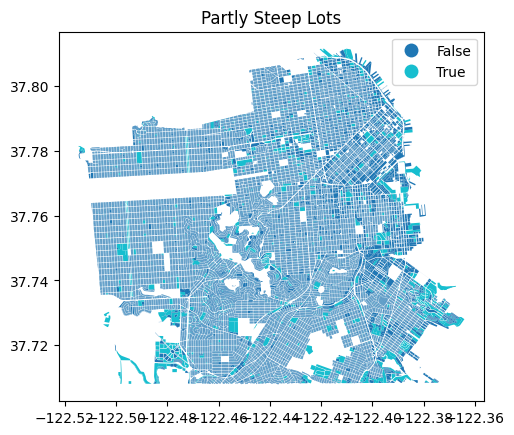

In [264]:
plt.clf()
full_df4_slopes2.plot(column='steep_lot', legend=True)
plt.title('Partly Steep Lots')
plt.show()

In [265]:
full_df4['entirely_steep_lot'] = full_df4_slopes.steep_lot

In [266]:
full_df4['partly_steep_lot'] = full_df4_slopes2.steep_lot

In [267]:
full_df4 = full_df4.reset_index(drop=True)

### Census Tracts

variable names explained here :
https://www.rand.org/content/dam/rand/www/external/labor/projects/dnors/pubs/pdfs/DNORS_contextual_block_listing.pdf

To make comparisons of racial demographics, age demographics, and family compositions comparable across tracts of different population densities, I divide each by the population of the tract in 2000.

In [268]:
# Drop columns that are all constant or whose inclusion creates perfect multicollinearity 
census = census.drop(['tractid', 'trt2000', 'state', 'objectid', 
                      'rural', 'urban', 'county', 'fipsstco', 
                      'owner_occ', 'other', 'males', 'age_under5',
                      'stfid'],
                     axis=1)

In [269]:
pop_variables = ['age_18_21', 'age_22_29', 'age_30_39', 'age_40_49', 'age_50_64',
                 'age_5_17', 'age_65_up', 
                 'ameri_es', 'asian', 'black', 'white',  'hawn_pi', 'mult_race', # races
                 'hispanic', # Hispanic is not a race
                 'renter_occ',
                 'females', 'hsehld_1_f', 'hsehld_1_m',
                 'families', 'marhh_no_c', 'marhh_chd', 'mhh_child', 'fhh_child']
census.loc[:, pop_variables] = census[pop_variables].apply(lambda x: x / census['pop2000'])

In [270]:
census.vacant = census.vacant / census.hse_units

In [271]:
census = census.add_prefix('census_')

In [272]:
census = census.rename({'census_geometry': 'geometry',
                        'census_ameri_es': 'census_native'}, axis=1)

In [ ]:
full_df4_census = gpd.sjoin_nearest(full_df4.to_crs('EPSG:26910'),
                                    census.to_crs('EPSG:26910'),
                                    how='left')

In [ ]:
full_df4_census.shape

In [ ]:
full_df4_census = full_df4_census.drop_duplicates(subset=['MapBlkLot_Master', 'mapblklot', 'blklot', 'active', 'geometry'])

In [ ]:
full_df4_census.shape

In [ ]:
full_df4_census = full_df4_census.drop(['index_right'], axis=1)

In [ ]:
full_df4 = full_df4_census

In [ ]:
full_df4 = full_df4.reset_index(drop=True)

### Home Prices

#### Make Zillow data geospatial for a geospatial join

In [ ]:
home_prices.RegionName = home_prices.RegionName.str.lower().str.split(' ').str.join('_')

In [ ]:
sfneighborhoods.name = sfneighborhoods.name.str.lower().str.split(' ').str.join('_')

In [ ]:
# I am replacing neighborhoods in Zillow data to match the sf open data neighborhood names.
neighborhood_map = {'mount_davidson_manor': 'mt._davidson_manor',
                    'haight': 'haight_ashbury',
                    'ingleside_terrace': 'ingleside_terraces',
                    'laurel_heights': 'laurel_heights_/_jordan_park',
                    'north_waterfront': 'northern_waterfront',
                    'marina_district': 'marina',
                    'ingleside_heights': 'merced_heights',
                    'lake': 'parkmerced'}

In [ ]:
assert all([k in sfneighborhoods.name.values.tolist() for k in neighborhood_map.values()])
assert all([k in home_prices.RegionName.values.tolist() for k in neighborhood_map.keys()])

In [ ]:
home_prices = home_prices.replace({'RegionName': neighborhood_map})

In [ ]:
neighborhoods_hp = pd.merge(sfneighborhoods, home_prices, left_on='name', right_on='RegionName', how='right')

In [ ]:
neighborhoods_hp = neighborhoods_hp.rename({'name': 'neighborhood', '2007-01-31': 'home_prices_jan07'}, axis=1)

In [ ]:
full_df4 = full_df4.replace({'neighborhood': {'dowtown': 'downtown',
                                             'croker_amazon': 'crocker_amazon',
                                             'ingleside_terrace': 'ingleside_terraces',
                                             'sea_cliff': 'seacliff',
                                             'lake_shore': 'lakeshore'}})

In [ ]:
# I am replacing neighborhoods in Zillow data to match the tax assessor neighborhood names.
# This may create mismatches between home_prices and sfneighborhoods but that's fine since that merge already happened
home_prices = home_prices.replace(
    {'RegionName' : {
        'buena_vista': 'buena_vista_park',
        'laurel_heights_/_jordan_park': 'jordan_park/laurel_heights', 
        'eureka_valley': 'eureka_valley/dolores_heights',
        'financial_district': 'financial_district_north',
        'civic_center': 'van_ness/_civic_center',
        'parnassus_heights': 'parnassus/ashbury_heights',
        'laguna_honda': 'forest_hill_extension',
        'mt._davidson_manor': 'mount_davidson_manor'
    }}
)

In [ ]:
full_df4_hp = full_df4.merge(home_prices.add_prefix('hp_'),
                             left_on='neighborhood',
                             right_on='hp_RegionName',
                             how='left')

In [ ]:
full_df4_hp = full_df4_hp.rename({'hp_2007-01-31': 'home_prices_jan07'}, axis=1)

In [ ]:
full_df4_hp = full_df4_hp.drop('hp_RegionName', axis=1)

In [ ]:
full_df4_hp = full_df4_hp.drop_duplicates(subset=['MapBlkLot_Master', 'mapblklot', 'blklot', 'active', 'geometry'])


In [ ]:
full_df4_hp.home_prices_jan07.notna().mean()

In [ ]:
full_df4_hp2 = gpd.sjoin_nearest(full_df4.to_crs('EPSG:26910'),
                                 neighborhoods_hp.drop('neighborhood', axis=1).to_crs('EPSG:26910'),
                                 how='left')

In [ ]:
full_df4_hp2 = full_df4_hp2.drop(['RegionName', 'index_right'], axis=1)

In [ ]:
#full_df4_hp2[['CANTID_blklot_backup', 'CANTID_geometry_backup']] = full_df4_hp2[['CANTID_blklot_backup',
#                                                                                 'CANTID_geometry_backup']].astype(str)

In [ ]:
full_df4_hp2 = full_df4_hp2.drop_duplicates(subset=['MapBlkLot_Master', 'mapblklot', 'blklot', 'active', 'geometry'])


In [ ]:
full_df4_hp.reindex()


In [ ]:
full_df4_hp2 = full_df4_hp2.reset_index(drop=True)

In [ ]:
full_df4_hp.home_prices_jan07 = full_df4_hp.home_prices_jan07.fillna(full_df4_hp2['home_prices_jan07'])

In [ ]:
full_df4_hp.home_prices_jan07.notna().mean()

In [ ]:
full_df4 = full_df4_hp

In [ ]:
plt.clf()
full_df4.plot(column='home_prices_jan07')
plt.show()

### Treat inclusion in site inventory as a feature

In [ ]:
full_df4 = clean_utils.get_site_inventory_feature(full_df4, sites, cycle=4)
#full_df5 = clean_utils.get_site_inventory_feature(full_df5, sites, cycle=4)

### Simplify names of tax variables

In [ ]:
tax_data_keys

In [ ]:
to_names = tax_data_keys['FIELD NAME'].str.lower().str.split(' ').str.join('_')
to_names = to_names.str.replace('closed_roll_', '')
to_names = to_names.str.replace('[\(\)\.]', '', regex=True)
to_names = to_names.str.replace('number_of_', 'n_', regex=False)
rename_map = {from_name: to_name for from_name, to_name in zip(tax_data_keys['DATA NAME'].tolist(), to_names)}

In [ ]:
full_df4 = full_df4.rename(rename_map, axis=1)

### Convert geometry to x, y coordinates

In [ ]:
# Get center point of parcel and store x, y as features
full_df4['x_coord'] = full_df4.geometry.representative_point().x
full_df4['y_coord'] = full_df4.geometry.representative_point().y

### Drop constant columns

In [ ]:
#full_df4 = full_df4.drop([c for c in full_df4.columns if 'CANTID' in c], axis=1)
#full_df5 = full_df5.drop([c for c in full_df5.columns if 'CANTID' in c], axis=1)

In [ ]:
full_df4 = full_df4.drop(full_df4.columns[full_df4.nunique() <= 1], axis=1)
#full_df5 = full_df5.drop(full_df5.columns[full_df5.nunique() <= 1], axis=1)

In [ ]:
full_df4 = full_df4.drop(['geometry', 'blklot', 'mapblklot', 'active', 'property_location', 'block_and_lot_number'], axis=1)

In [ ]:
full_df4 = full_df4.rename({'Envelope_1000': 'buildable_envelope_1000'}, axis=1)

In [ ]:
full_df4['existing_envelope_1000'] = ( 1 / full_df4['Upzone_Ratio']) * full_df4['buildable_envelope_1000']

In [ ]:
# full_df5 = full_df5.drop(['geometry', 'blklot', 'mapblklot', 'active', 'property_location', 'block_and_lot_number'], axis=1)

In [ ]:
full_df4.to_csv('cleaned_rhna4_data.csv', index=False)
#full_df5.to_csv('cleaned_rhna5_data.csv', index=False)

In [154]:
rhna = sites[sites['rhnacyc'] == 'RHNA4']
rhna = rhna[rhna.jurisdict == 'San Francisco']



In [148]:
sf_si_april = pd.read_excel('../data/HCD_List.xls', skiprows=1)

In [151]:
sf_si_april = sf_si_april.iloc[:-1, :]

In [167]:
rhna[~rhna.locapn.isin(sf_si_april.APN)].sample(10)

,objectid,rhnacyc,rhnayrs,county,jurisdict,apn,locapn,genplan,zoning,gacres,...,infcapcty,siteconst,sitetype,pdaparcel,bundled,existuse,localnote,Shape__Are,Shape__Len,geometry
10702,52836,RHNA4,2007-2014,6075,San Francisco,5807/009,5807/009,RH-2,NaN,0.053,...,NaN,NaN,Underutilized,NaN,NaN,DWELLING,NaN,2.187744e-08,0.000593,"POLYGON ((-122.41825 37.73420, -122.41827 37.7..."
5480,47614,RHNA4,2007-2014,6075,San Francisco,3518/009,3518/009,RED MIXED,NaN,0.057,...,NaN,NaN,Underutilized,Y,NaN,INDUSTRIAL,NaN,2.378147e-08,0.000782,"POLYGON ((-122.41226 37.77411, -122.41250 37.7..."
13092,55226,RHNA4,2007-2014,6075,San Francisco,3521/003,3521/003,W SoMa MUG,NaN,0.084,...,NaN,NaN,Underutilized,Y,NaN,INDUSTRIAL,NaN,3.495552e-08,0.000790,"POLYGON ((-122.41365 37.77140, -122.41385 37.7..."
10778,52912,RHNA4,2007-2014,6075,San Francisco,5898/035,5898/035,RH-1,NaN,0.040,...,NaN,NaN,Vacant,NaN,NaN,VACANT,NaN,1.650369e-08,0.000658,"POLYGON ((-122.41988 37.72935, -122.41989 37.7..."
9657,51791,RHNA4,2007-2014,6075,San Francisco,6360/001,6360/001,RH-1,NaN,1.652,...,NaN,NaN,NaN,Y,NaN,MISC/UNKNOWN,MISC/UNKNOWN,6.836017e-07,0.007185,"POLYGON ((-122.41494 37.70998, -122.41501 37.7..."
6895,49029,RHNA4,2007-2014,6075,San Francisco,2923/078,2923/078,RH-1(D),NaN,0.107,...,NaN,NaN,Vacant,NaN,NaN,VACANT,NaN,4.430467e-08,0.000991,"POLYGON ((-122.45973 37.74148, -122.45975 37.7..."
12173,54307,RHNA4,2007-2014,6075,San Francisco,3771/002,3771/002,SB-DTR,NaN,1.756,...,NaN,NaN,Vacant,Y,NaN,VACANT,NaN,7.272429e-07,0.004113,"POLYGON ((-122.38820 37.78632, -122.38828 37.7..."
10895,53029,RHNA4,2007-2014,6075,San Francisco,4161/028,4161/028,RH-2,NaN,0.057,...,NaN,NaN,Underutilized,Y,NaN,DWELLING,NaN,2.374964e-08,0.000723,"POLYGON ((-122.39920 37.75481, -122.39929 37.7..."
6040,48174,RHNA4,2007-2014,6075,San Francisco,2348/001,2348/001,RH-2,NaN,0.205,...,NaN,NaN,Underutilized,NaN,NaN,GAS STATION,NaN,8.486722e-08,0.001167,"POLYGON ((-122.47593 37.74453, -122.47624 37.7..."
5809,47943,RHNA4,2007-2014,6075,San Francisco,4991/625,4991/625,C-2,NaN,1.123,...,NaN,NaN,NaN,Y,NaN,NaN,NaN,4.646899e-07,0.003262,"POLYGON ((-122.39227 37.71223, -122.39193 37.7..."


In [168]:
sf_si_april[~sf_si_april.APN.isin(rhna.apn)].sample(10)

,APN,Existing Use,Zoning,Lot Area (Acres),Estimated Net Units Potential
101,0571/014,VACANT,RH-3,0.078914,3
978,0496/007,MOTEL,NC-3,0.236743,2
768,0040/033,COMMERCIAL,C-2,0.104113,1
174,0793/079,PARKING LOT,NCT-3,0.189352,10
1030,0546/005,CHURCH,RC-3,0.037879,2
2922,5353A/008,COMMERCIAL,NC-1,0.2655,14
819,0158/001,VACANT,RM-2,0.112055,8
121,0658/003,MISC/UNKNOWN,RH-3,0.297578,12
1259,0823/008,MISC/UNKNOWN,RM-1,0.086805,4
1292,0869/007,VACANT,RTO,0.075902,6


In [165]:
rhna.locapn.isin(sf_si_april.APN).mean()

0.4934839270199826

In [166]:
rhna.apn.isin(sf_si_april.APN).mean()

0.5603822762814944

In [158]:
sf_si_april.APN.isin(rhna.apn).mean()

0.7460087082728593

In [159]:
sf_si_april.APN.isin(rhna.locapn).mean()

0.6566037735849056

In [169]:
sf_si_april.shape

(3445, 5)

In [170]:
rhna.shape

(4604, 35)